In [1]:
'''
author: Yike Xie
data: 22/Dec/2023
content: check the correlation coefficients of representative
         receptors of MCF-7 cells
'''

'\nauthor: Yike Xie\ndata: 22/Dec/2023\ncontent: check the correlation coefficients of representative\n         receptors of MCF-7 cells\n'

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False, rho=False, ):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median() # average expression
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/(max(med) + 0.001) for i in med] # avoid average expression is 0
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, 
                  edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')
    
    if rho is not False:
        ax.text(0.5, ax.get_yticks()[-4], r'$\rho$={}'.format(round(rho, 2)))

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}


In [4]:
def kdes(corr, fea, path=False):
    from matplotlib.lines import Line2D
    rcParams['pdf.fonttype'] = 42

    fig, ax = plt.subplots(figsize=[3,3])
    cs = sns.color_palette('tab10', 3)

    handles = []
    labels = []
    for i, c in zip([0, 10, 50], cs):
        sns.kdeplot(data=corr[corr['Number'] > i], x=fea, lw=2, 
                    ax=ax, c=c)
        handles.append(Line2D([], [], color=c, lw=2))
        labels.append('≥{} cells'.format(str(i)))

    ax.legend(handles=handles, labels=labels, loc='upper left', 
              bbox_to_anchor=[1, 1], title='Genes expressed by')
    ax.set_xlabel(r'$\rho$ [{} vs. Exp]'.format(fea.capitalize()))
    ax.set_ylabel('Density')

    if path is not False:
        fig.savefig(path + '{}_kde_0_10_50.pdf'.format(fea), dpi=150, bbox_inches='tight')
        
def kde_fea(corr, n, fea, genes, colors, path=False):
    
    rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(figsize=[2.5,2.5])
    sns.kdeplot(data=corr[corr['Number'] > n], x=fea, lw=2, 
                ax=ax, c='gray')
    ax.set_title('Genes expressed by ≥{} cells'.format(str(n)))
    ax.set_xlabel(r'$\rho$ [{} vs. Exp]'.format(fea.capitalize()))
    ax.set_ylabel('Density')
    ax.grid(lw=1, ls='--', zorder=-5, alpha=0.5)

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    points = list(zip(x, y))
    t_dic = dict(points)

    x_trues = [corr.loc[gene][fea] for gene in genes]
    x_points = []
    y_points = []
    for x in x_trues:
        x_point = find_nearest(np.array(list(t_dic.keys())), x)
        x_points.append(x_point)
        y_points.append(t_dic[x_point])

    sns.scatterplot(x = x_points,
                    y = y_points, c=colors, s=50)

    for gene, x, y, c in zip(genes, x_points, y_points, colors):
        ax.annotate(gene, xy=(x, y), xytext=(x, y+0.8), arrowprops=dict(arrowstyle="<-"), 
                    va='center', ha='center', color=c)

    if path is not False:
        fig.savefig(path + '{}_kde.pdf'.format(fea), dpi=150, bbox_inches='tight')

    return {'fig': fig, 'ax': ax}

In [5]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/combine_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/combine_gene.h5ad'
adata = sig_dataset(feas_fn, data_fn)

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/'

# add average optical intensity to adata
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
for col in df.columns:
    adata.obs['{}_{}'.format(col[0], col[1])] = df.loc[adata.obs_names][col]
    
adata.obs['C4_C2'] = df[df.columns[3]] / df[df.columns[1]]

adata.obs['area um2'] = adata.obs['area'] * 339.08276 ** 2 / 1024 ** 2

load features
load dataset
filter genes
Add features to adata


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


## focus following analyses on cells with low percentage of mitochondrial reads

In [6]:
## divide live and dead cells according to the fraction o mitochondrial reads
live_cells = adata.obs[adata.obs['pct_counts_mt'] < 25].index
dead_cells = adata.obs[adata.obs['pct_counts_mt'] > 25].index

# create dataset only having cells with low percentage of mitochondrial reads
adata_live = adata[live_cells, :]

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [7]:
def plot_bins(adata, fea, bin_n, gene, cmap, xlabel, filetype, path=False, rho=False, ):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 2.5])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median() # average expression
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/(max(med) + 0.001) for i in med] # avoid average expression is 0
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, 
                  edgecolor='white', linewidth=1, size=3)

    bins = np.array_split(adata.obs[fea].sort_values().array, 8)
    round_n = [0, 2]['.' in str(bins[0])]
#     round_n = 0
    xticklabels = [f'{f"%.{round_n}f" % (i.min())}-{f"%.{round_n}f" % (i.max())}' for i in bins]
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_xlabel(xlabel)
#     ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')
    
    if rho is not False:
        ax.text(0.5, ax.get_yticks()[-4], r'$\rho$={}'.format(round(rho, 2)))

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

In [8]:
save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/'

morph_corr = pd.read_csv(save_figures + 'correlation_live_cells.tsv', 
                         sep='\t', index_col=0)
morph_corr['area um2'] = morph_corr['area']

wls_corr = pd.read_csv(save_figures + 'spectra_gene_correlation_live_cells.tsv', 
                       sep='\t', index_col=0).fillna(0)

ratio_corr = pd.read_csv(save_figures + 'C4_C2/correlation_ratio_4_2_live_cells.tsv', 
                         sep='\t', index_col=0).fillna(0)

In [11]:
receptors = [
    'ESR1', # Estrogen receptors
    'PGR', # Progesterone Receptor
    'AR', # Androgen Receptor
    'NR3C1', # Glucocorticoid receptor
    'TNFRSF1A', # TNF-alpha receptors
]
wls_corr.loc[receptors]['343_451']

gene_name
ESR1        0.260300
PGR         0.235638
AR          0.136664
NR3C1       0.251410
TNFRSF1A    0.217240
Name: 343_451, dtype: float64

In [12]:
ratio_corr.loc[receptors]['C4_C2']

gene_name
ESR1       -0.038347
PGR        -0.005346
AR         -0.069580
NR3C1      -0.045951
TNFRSF1A   -0.012739
Name: C4_C2, dtype: float64

In [13]:
morph_corr.loc[receptors]

,area,eccentricity,spectra_norm,Frac,Number,area um2
gene_name,,,,,,
ESR1,-0.051306,-0.008299,0.262326,59.663866,71,-0.051306
PGR,0.003633,0.143505,0.238014,15.126050,18,0.003633
AR,0.106785,-0.071693,0.042391,26.050420,31,0.106785
NR3C1,0.160448,0.083986,0.175191,56.302521,67,0.160448
TNFRSF1A,0.034374,-0.024095,0.268864,57.142857,68,0.034374


In [14]:
heatmap_df = pd.DataFrame(index=receptors, 
                          columns=['Area', 'Eccentricity','C4/C2',  'C4', ])

heatmap_df['Area'] = morph_corr.loc[receptors]['area']
heatmap_df['Eccentricity'] = morph_corr.loc[receptors]['eccentricity']

heatmap_df['C4'] = wls_corr.loc[receptors]['343_451']

heatmap_df['C4/C2'] = ratio_corr.loc[receptors]['C4_C2']

In [15]:
heatmap_df

,Area,Eccentricity,C4/C2,C4
ESR1,-0.051306,-0.008299,-0.038347,0.260300
PGR,0.003633,0.143505,-0.005346,0.235638
AR,0.106785,-0.071693,-0.069580,0.136664
NR3C1,0.160448,0.083986,-0.045951,0.251410
TNFRSF1A,0.034374,-0.024095,-0.012739,0.217240


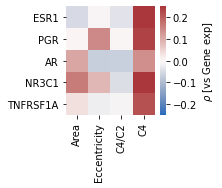

In [16]:
fig, ax = plt.subplots(figsize=[2, 2])
rcParams['pdf.fonttype'] = 42
sns.heatmap(heatmap_df, center=0, cmap='vlag', vmin = -0.25, vmax=0.25, 
                cbar_kws={'label': r'$\rho$ [vs Gene exp]'})
plt.savefig(save_figures + 'MCF7/MCF7_receptors.png', bbox_inches='tight', dpi=300)
plt.savefig(save_figures + 'MCF7/MCF7_receptors.pdf', bbox_inches='tight', dpi=300)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

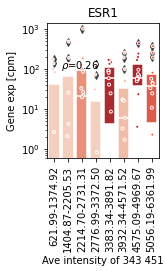

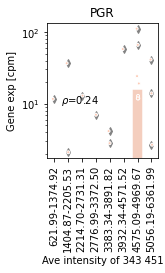

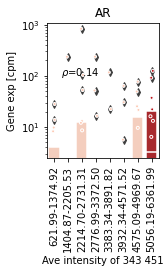

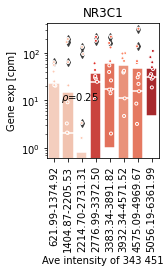

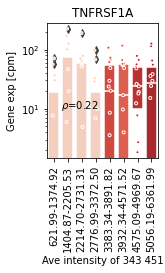

In [17]:
for gene in receptors:
    fea = '343_451'
    genes = [gene]
    colors = ['Reds']
    cmap = 'Reds'
    bin_n = 8
    
    rho = wls_corr.loc[gene][fea]
    plot_bins(adata_live, fea, bin_n, gene, cmap, 'Ave intensity of 343 451', '.pdf', 
              path=save_figures + 'MCF7/', rho=rho)